In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy.stats import multivariate_normal, expon, probplot

In [2]:
df = pd.read_csv('./data/galaxy_noise.csv', index_col=0)
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold,index,...,color_sentiment,color_sentiment2,carrier_NaN,carrier_none,productline_imputed,productline_imputed2,productSeries_imputed,product_isNote_imputed,productSeries_imputed2,product_isNote_imputed2
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1,0,...,0,0,0,1,Galaxy_S9,Galaxy_S9,2,0,2,0
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0,1,...,0,-1,0,1,Galaxy_Note9,Galaxy_Note9,2,1,2,1
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0,2,...,0,-1,1,-1,Galaxy_S8,Galaxy_S10,1,0,3,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1,3,...,1,1,0,0,Galaxy_Note9,Galaxy_Note9,2,1,2,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1,4,...,1,1,0,1,Galaxy_S8,Galaxy_S8,1,0,1,0


In [39]:
df.sold.value_counts()

0    799
1    686
Name: sold, dtype: int64

In [3]:
df.columns

Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
       'noDescription', 'charCountDescription', 'upperCaseDescription', 'sold',
       'index', 'color_NaN', 'color_sentiment', 'color_sentiment2',
       'carrier_NaN', 'carrier_none', 'productline_imputed',
       'productline_imputed2', 'productSeries_imputed',
       'product_isNote_imputed', 'productSeries_imputed2',
       'product_isNote_imputed2'],
      dtype='object')

# df.noDescription
# df.charCountDescription
# df.upperCaseDescription

Check list
- BuyItNow와의 관련성
    - BuyItNow -> 급매, 중고 등 부가적인 사유가 존재함
    - 부가적인 사유를 상품설명에 기재하는 경우가 많을 것으로 기대
   

In [4]:
df[['noDescription', 'charCountDescription', 'upperCaseDescription']].head()

,noDescription,charCountDescription,upperCaseDescription
0,contains description,0,0
1,contains description,0,0
2,no description,100,2
3,contains description,0,0
4,contains description,0,0


In [5]:
df.noDescription.value_counts()

contains description    856
no description          629
Name: noDescription, dtype: int64

In [6]:
df['hasDescription'] = df['noDescription'].apply(lambda x: 0 if x == 'contains description'
                                                else 1)

In [7]:
# BuyItNow인 상품의 39%는 설명 텍스트가 존재
# BuyItNow가 아닌 상품의 45%는 설명 텍스트가 존재
# 사정이 있어 글을 적는다기보다, 비싸게 내놓을 때 구매촉진을 위해 뭔가를 적는 비율이 많다고 보는게 자연스러울 듯
df.groupby('BuyItNow')[['hasDescription', 'startprice']].mean()

,hasDescription,startprice
BuyItNow,,
0,0.454768,288.124927
1,0.385307,129.426372


In [8]:
# 설명문구 없는 상품의 시작가가 더 비싸다
df.groupby('hasDescription')['startprice'].mean()

hasDescription
0    232.487593
1    195.555167
Name: startprice, dtype: float64

In [9]:
df.groupby('hasDescription')[['charCountDescription', 'upperCaseDescription']].mean()

,charCountDescription,upperCaseDescription
hasDescription,,
0,0.000000,0.000000
1,73.623211,6.759936


### def.charCountDescription
균일하거나 정규성이 존재하지 않는 분포, 3개 구간으로 분리
1. 아예 작성하지 않음
    - charCount == 0
2. 적당히 작성함
    - 0 < charCount < 90
3. 길게 작성함
    - 90 < charCount
    
> 다른 변수와의 관계 조사 결과:

> "아예 작성하지 않음"과 "적당히 작성함"은 sold, BuyItNow에 대하여 유사한 구별력을 갖는다

> "아예 작성하지 않음"과 "적당히 작성함"은 0, "길게 작성함"은 1인 binary 컬럼으로 수정.

<AxesSubplot:xlabel='charCountDescription', ylabel='Count'>

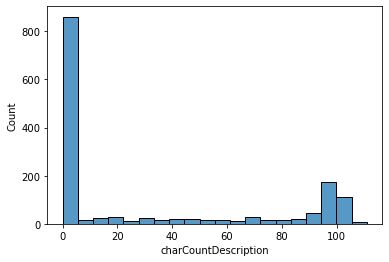

In [10]:
sns.histplot(df['charCountDescription'], bins=20)
# charCount == 0
# 0 < charCount < 90
# 90 < charCount

In [11]:
df['charCountDescriptionBins'] = df['charCountDescription'].apply(lambda x: 0 if x==0
                                                                    else 1 if (x<90)
                                                                    else 2)

In [12]:
df['charCountDescriptionBins'].value_counts()

0    856
2    334
1    295
Name: charCountDescriptionBins, dtype: int64

In [13]:
df.groupby('charCountDescriptionBins')['sold'].mean()

charCountDescriptionBins
0    0.482477
1    0.488136
2    0.386228
Name: sold, dtype: float64

In [14]:
df.groupby('charCountDescriptionBins')['BuyItNow'].mean()

charCountDescriptionBins
0    0.478972
1    0.477966
2    0.347305
Name: BuyItNow, dtype: float64

<AxesSubplot:xlabel='startprice', ylabel='Count'>

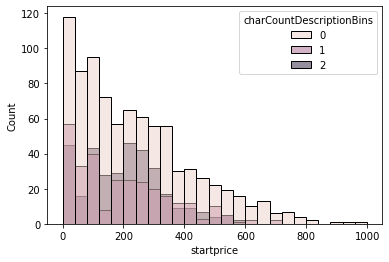

In [15]:
sns.histplot(x='startprice', data=df, hue='charCountDescriptionBins')

In [16]:
df.groupby('charCountDescriptionBins')['productline'].value_counts()

charCountDescriptionBins  productline  
0                         Galaxy_Note10    220
                          Galaxy_S8        173
                          Galaxy_S7        123
                          Unknown          119
                          Galaxy_S9         74
                          Galaxy_Note8      71
                          Galaxy_Note9      70
                          Galaxy_S10         6
1                         Galaxy_Note10     69
                          Galaxy_S8         53
                          Galaxy_S7         50
                          Unknown           40
                          Galaxy_Note8      33
                          Galaxy_S9         32
                          Galaxy_Note9      17
                          Galaxy_S10         1
2                         Galaxy_Note10     62
                          Galaxy_S7         54
                          Galaxy_S9         52
                          Galaxy_S8         51
                    

In [17]:
df['charCountDescriptionBins'] = df['charCountDescriptionBins'].apply(lambda x:
                                                                     0 if x<2
                                                                      else 1)

In [18]:
df['charCountDescriptionBins'].value_counts()

0    1151
1     334
Name: charCountDescriptionBins, dtype: int64

### df.charCountDescription

<AxesSubplot:xlabel='upperCaseDescription', ylabel='Count'>

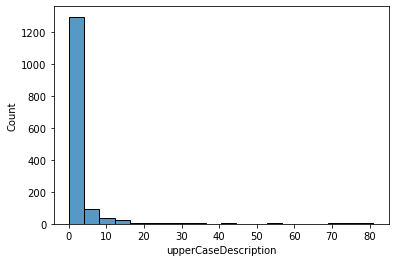

In [19]:
sns.histplot(df['upperCaseDescription'], bins=20)

<AxesSubplot:xlabel='upperCaseDescription', ylabel='Count'>

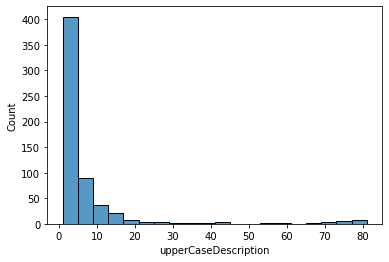

In [20]:
sns.histplot(df[df['upperCaseDescription']>0]['upperCaseDescription'], bins=20)

In [21]:
df.groupby('charCountDescriptionBins')['upperCaseDescription'].mean()

charCountDescriptionBins
0    1.131190
1    8.832335
Name: upperCaseDescription, dtype: float64

### 설명을 길게 썼으면 대문자도 많을 것이다?
- 그렇지만도 않음
- 설명 글자 갯수와는 다른 randomness 정보를 갖고 있을 것으로 기대.
- 구간을 나누는 것이 의미있을지 확인해보자

Text(0, 0.5, 'upperCaseDescription')

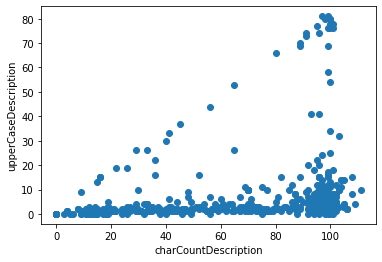

In [22]:
plt.scatter(df['charCountDescription'], df['upperCaseDescription'])
plt.xlabel('charCountDescription')
plt.ylabel('upperCaseDescription')

<AxesSubplot:xlabel='upperCaseDescription', ylabel='Count'>

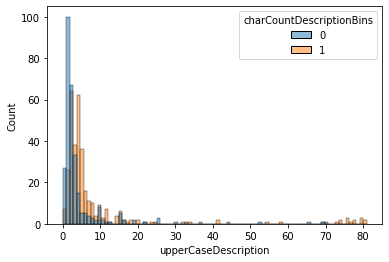

In [23]:
sns.histplot(x='upperCaseDescription',
             data=df[df['charCountDescription'] > 0], hue='charCountDescriptionBins')

<AxesSubplot:xlabel='upperCaseDescription', ylabel='Count'>

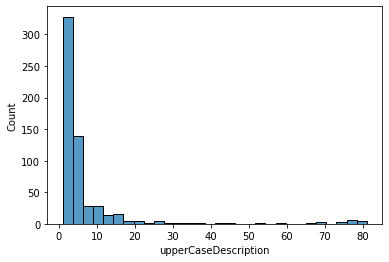

In [24]:
sns.histplot(df[df['upperCaseDescription']>0]['upperCaseDescription'], bins=30)

### 대문자 20개 이상인 매물 데이터 조사
- 대부분의 경우 전체 설명글의 50% 이상을 대문자로 작성하였음
- 굉장히 부담스럽게 다가올수도?
    
    > (1) 전체 설명문 글자수 대비 대문자 글자수의 비율로 변환
    
    > (2) ==0, <20, >20 3개 구간으로 구분

In [25]:
df[df['upperCaseDescription']>20][['charCountDescription','upperCaseDescription']].head()

,charCountDescription,upperCaseDescription
9,96,41
138,40,30
320,80,66
330,101,76
359,41,33


In [26]:
df[df['upperCaseDescription']>20]['sold'].mean(), df[df['upperCaseDescription']>10]['BuyItNow'].mean()

(0.3611111111111111, 0.4025974025974026)

In [27]:
print(df[(df['upperCaseDescription']<20) & (df['upperCaseDescription']>0)]['sold'].mean(),
      df[(df['upperCaseDescription']<20) & (df['upperCaseDescription']>0)]['BuyItNow'].mean())

0.42908438061041293 0.3985637342908438


In [28]:
df[df['upperCaseDescription']==0]['sold'].mean(), df[df['upperCaseDescription']==0]['BuyItNow'].mean()

(0.48764044943820223, 0.4820224719101124)

In [29]:
df['upperCaseDescriptionBins'] = df['upperCaseDescription'].apply(lambda x: 0 if x==0 else
                                                                    1 if x < 20 else 2)

In [30]:
df['upperCaseDescription_rate'] = [uc/c if c!=0 else 0 for (c, uc)
                                    in zip(df['charCountDescription'], df['upperCaseDescription'])]

In [31]:
df[df['upperCaseDescription']>50]['sold'].mean()

0.2857142857142857

In [32]:
df[df['upperCaseDescription_rate']>.5]['sold'].mean()

0.4

In [33]:
df.groupby('productline')['upperCaseDescription_rate'].mean()

productline
Galaxy_Note10    0.036261
Galaxy_Note8     0.033298
Galaxy_Note9     0.046197
Galaxy_S10       0.031250
Galaxy_S7        0.048262
Galaxy_S8        0.038550
Galaxy_S9        0.067014
Unknown          0.035985
Name: upperCaseDescription_rate, dtype: float64

In [34]:
df.groupby('sold')['upperCaseDescription_rate'].mean()

sold
0    0.045079
1    0.038717
Name: upperCaseDescription_rate, dtype: float64

<AxesSubplot:>

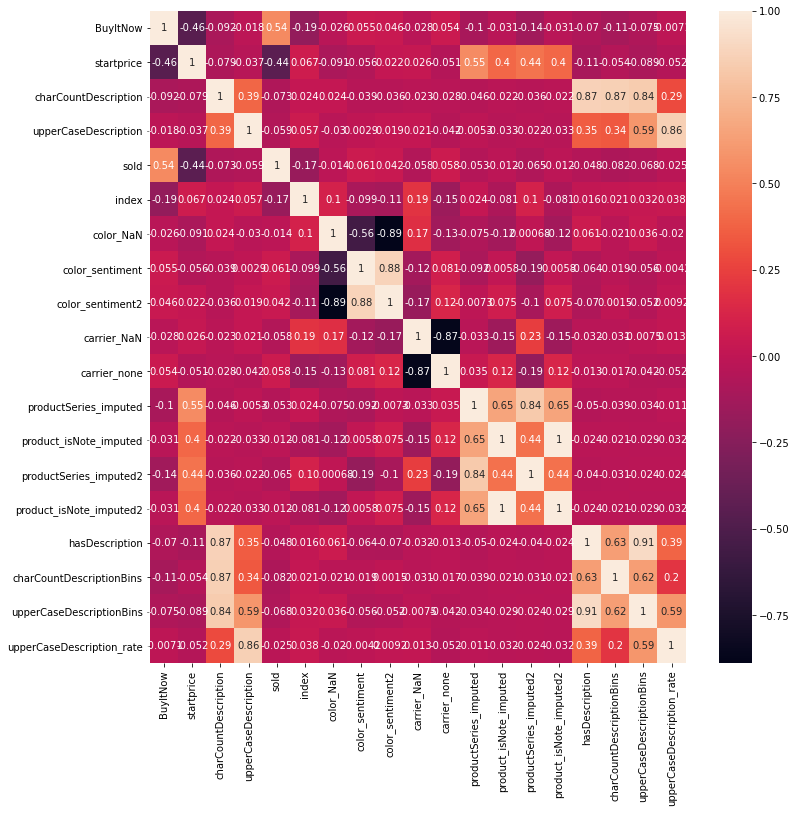

In [35]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)

# startprice
productline, BuyItNow, sold에 대한 개별 startprice 집합의 평균과 표준편차를 계산
- startprice를 각각의 표본 통계치로 standard scaling
- 선 하나를 그어서 sold, not sold를 구분할 수 있을까?

> FAIL

In [93]:
df.columns

Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
       'noDescription', 'charCountDescription', 'upperCaseDescription', 'sold',
       'index', 'color_NaN', 'color_sentiment', 'color_sentiment2',
       'carrier_NaN', 'carrier_none', 'productline_imputed',
       'productline_imputed2', 'productSeries_imputed',
       'product_isNote_imputed', 'productSeries_imputed2',
       'product_isNote_imputed2', 'hasDescription', 'charCountDescriptionBins',
       'upperCaseDescriptionBins', 'upperCaseDescription_rate'],
      dtype='object')

In [94]:
price_by_bps_mean = df.groupby(['BuyItNow', 'productline', 'sold'])['startprice'].mean()
price_by_bps_std = df.groupby(['BuyItNow', 'productline', 'sold'])['startprice'].std()

pd.concat([price_by_bps_mean, price_by_bps_std], axis=1)

startprice  startprice
BuyItNow productline   sold                        
0        Galaxy_Note10 0     468.784540  151.063692
                       1     400.213243  126.137797
         Galaxy_Note8  0     258.026102  115.545331
                       1     198.411765   57.352077
         Galaxy_Note9  0     317.981957   90.610241
                       1     325.262000  101.825963
         Galaxy_S10    0     296.917500   47.263311
                       1     336.333333   85.031367
         Galaxy_S7     0     126.981750   55.854296
                       1      84.726897   43.005072
         Galaxy_S8     0     248.551759  126.225511
                       1     182.019697   67.573664
         Galaxy_S9     0     317.914054  106.673186
                       1     232.071053   79.149773
         Unknown       0     208.135000  150.850342
                       1     232.497692  166.012178
1        Galaxy_Note10 0     416.711071  157.272237
                       1     185.255179  163.210379
         Galaxy_Note8  0     198.855000   96.602136
                       1      88.213333   82.267983
         Galaxy_Note9  0     267.911667   96.447946
                       1     132.853824   96.252107
         Galaxy_S10    1     160.000000         NaN
         Galaxy_S7     0     122.860000   97.206543
                       1      39.506146   37.346137
         Galaxy_S8     0     173.103243   89.914461
                       1      67.622424   62.255231
         Galaxy_S9     0     236.517368  104.836709
                       1      89.381304   80.056522
         Unknown       0     216.254286  176.513101
                       1      61.108571   78.411165

In [95]:
sold0 = df['sold']==0
sold1 = df['sold']==1
bin0 = df['BuyItNow']==0
bin1 = df['BuyItNow']==1

In [96]:
productline_unique = sorted(df['productline'].unique().tolist(), reverse=True)
idx_by_productline = [(df['productline'] == unq) for unq in productline_unique]

In [97]:
idx_by_prd_sold_bin = [(idxp & sold & bin_) for idxp in idx_by_productline
                       for bin_ in [bin0, bin1] 
                       for sold in [sold0, sold1]
                      ]

In [98]:
masks = sorted(productline_unique * 4, reverse=True)
postfix = ['_bin0_sold0', '_bin0_sold1', '_bin1_sold0', '_bin1_sold1']
mask_names = [m+postfix[i%4] for i, m in enumerate(masks)]
mask_names

['Unknown_bin0_sold0',
 'Unknown_bin0_sold1',
 'Unknown_bin1_sold0',
 'Unknown_bin1_sold1',
 'Galaxy_S9_bin0_sold0',
 'Galaxy_S9_bin0_sold1',
 'Galaxy_S9_bin1_sold0',
 'Galaxy_S9_bin1_sold1',
 'Galaxy_S8_bin0_sold0',
 'Galaxy_S8_bin0_sold1',
 'Galaxy_S8_bin1_sold0',
 'Galaxy_S8_bin1_sold1',
 'Galaxy_S7_bin0_sold0',
 'Galaxy_S7_bin0_sold1',
 'Galaxy_S7_bin1_sold0',
 'Galaxy_S7_bin1_sold1',
 'Galaxy_S10_bin0_sold0',
 'Galaxy_S10_bin0_sold1',
 'Galaxy_S10_bin1_sold0',
 'Galaxy_S10_bin1_sold1',
 'Galaxy_Note9_bin0_sold0',
 'Galaxy_Note9_bin0_sold1',
 'Galaxy_Note9_bin1_sold0',
 'Galaxy_Note9_bin1_sold1',
 'Galaxy_Note8_bin0_sold0',
 'Galaxy_Note8_bin0_sold1',
 'Galaxy_Note8_bin1_sold0',
 'Galaxy_Note8_bin1_sold1',
 'Galaxy_Note10_bin0_sold0',
 'Galaxy_Note10_bin0_sold1',
 'Galaxy_Note10_bin1_sold0',
 'Galaxy_Note10_bin1_sold1']

In [99]:
df['startprice_standardized'] = df['startprice'].copy()
for (mask_name, mask_idx) in zip(mask_names, idx_by_prd_sold_bin):
    mean = df[mask_idx]['startprice'].mean()
    try:
        std = df[mask_idx]['startprice'].std()
    except:
        std = 1
    
    df.loc[mask_idx, 'startprice_standardized'] = (df.loc[mask_idx, 'startprice_standardized'] - mean) / std

In [100]:
df[['BuyItNow','productline','startprice','startprice_standardized', 'sold']]

,BuyItNow,productline,startprice,startprice_standardized,sold
0,0,Galaxy_S9,199.99,-0.405321,1
1,0,Galaxy_Note9,235.00,-0.915812,0
2,0,Unknown,199.99,-0.053994,0
3,1,Galaxy_Note9,175.00,0.437873,1
4,1,Galaxy_S8,100.00,0.520078,1
...,...,...,...,...,...
1480,0,Galaxy_S7,89.50,-0.671063,0
1481,0,Galaxy_S9,239.95,0.099545,1
1482,0,Galaxy_Note10,329.99,-0.918782,0
1483,0,Galaxy_S7,89.00,0.099363,1


In [101]:
df.groupby('sold')['startprice_standardized'].mean()*10**15

sold
0    0.096398
1    0.176197
Name: startprice_standardized, dtype: float64

In [102]:
df['startprice_minmax'] = df['startprice'].copy()
for (mask_name, mask_idx) in zip(mask_names, idx_by_prd_sold_bin):
    min_ = df[mask_idx]['startprice'].min()
    max_ = df[mask_idx]['startprice'].max()
    
    df.loc[mask_idx, 'startprice_minmax'] = (df.loc[mask_idx, 'startprice_minmax'] - min_) / (max_-min_)

<AxesSubplot:xlabel='startprice', ylabel='Count'>

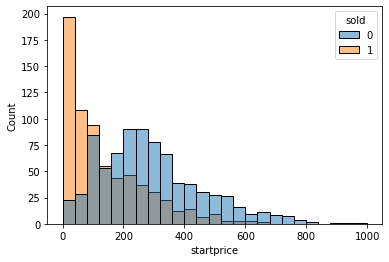

In [103]:
sns.histplot(x='startprice', data=df, hue='sold')

<AxesSubplot:xlabel='startprice_standardized', ylabel='Count'>

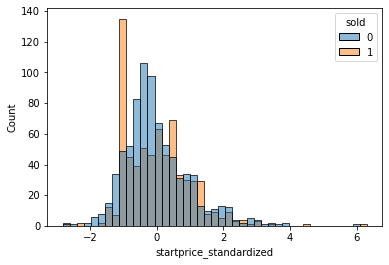

In [104]:
sns.histplot(x='startprice_standardized', data=df, hue='sold')

<AxesSubplot:xlabel='startprice_minmax', ylabel='Count'>

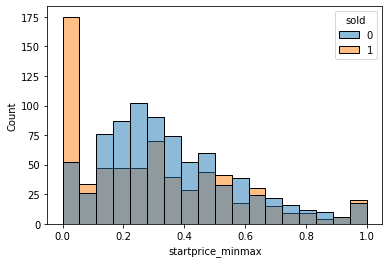

In [105]:
sns.histplot(x='startprice_minmax', data=df, hue='sold')

<AxesSubplot:xlabel='startprice_log', ylabel='Count'>

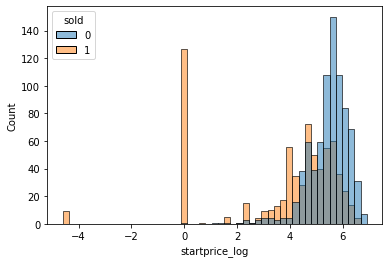

In [106]:
df['startprice_log'] = np.log(df['startprice'])
sns.histplot(x='startprice_log', data=df, hue='sold')

<AxesSubplot:xlabel='startprice_sqrd', ylabel='Count'>

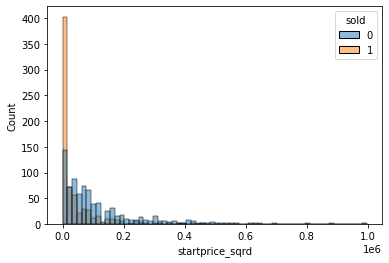

In [107]:
df['startprice_sqrd'] = df['startprice']**2
sns.histplot(x='startprice_sqrd', data=df, hue='sold')

#### 어디까지가 '후려친 가격'인가?

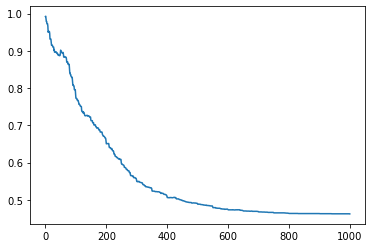

In [108]:
plt.plot([df[df['startprice']<i]['sold'].mean() for i in range(1, 1001)])

# df.startprice

> 소수점 첫번째 자리가 '9'인 가격과 그렇지 않은 가격의 차이?

In [36]:
df['startprice_point9'] = df['startprice'].apply(lambda x: 1 if str(x).split('.')[1][0]=='9' else 0)

In [37]:
pd.concat([df['startprice_point9'],
           df['startprice']], axis=1)

,startprice_point9,startprice
0,1,199.99
1,0,235.00
2,1,199.99
3,0,175.00
4,0,100.00
...,...,...
1480,0,89.50
1481,1,239.95
1482,1,329.99
1483,0,89.00


In [38]:
df.groupby('startprice_point9')['sold'].mean()

startprice_point9
0    0.461783
1    0.462247
Name: sold, dtype: float64

In [ ]:
df.groupby('startprice_point9')['sold'].mean()

In [111]:
df.groupby('startprice_point9')['BuyItNow'].mean()

startprice_point9
0    0.458599
1    0.432781
Name: BuyItNow, dtype: float64

<AxesSubplot:>

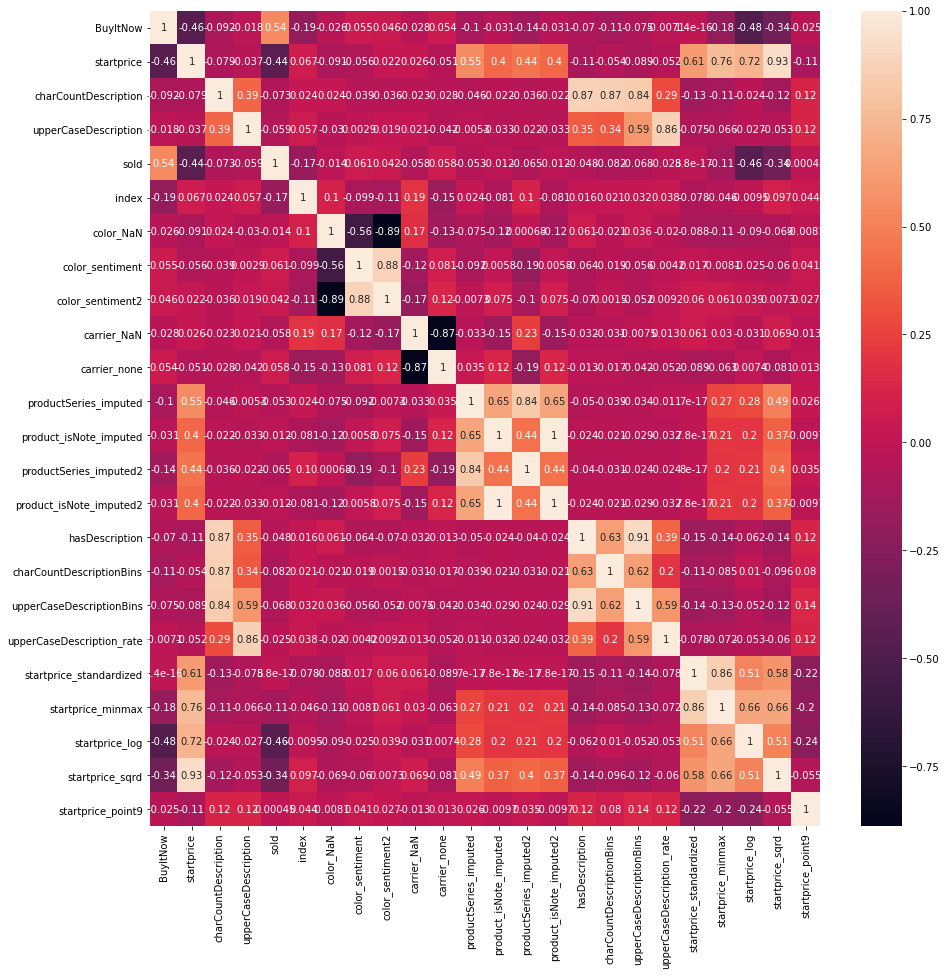

In [112]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

# Finalize Dataset

In [113]:
len(df.columns), df.columns

(30,
 Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
        'noDescription', 'charCountDescription', 'upperCaseDescription', 'sold',
        'index', 'color_NaN', 'color_sentiment', 'color_sentiment2',
        'carrier_NaN', 'carrier_none', 'productline_imputed',
        'productline_imputed2', 'productSeries_imputed',
        'product_isNote_imputed', 'productSeries_imputed2',
        'product_isNote_imputed2', 'hasDescription', 'charCountDescriptionBins',
        'upperCaseDescriptionBins', 'upperCaseDescription_rate',
        'startprice_standardized', 'startprice_minmax', 'startprice_log',
        'startprice_sqrd', 'startprice_point9'],
       dtype='object'))

In [114]:
df.to_csv('./data/galaxy_shotgun.csv', encoding='utf-8-sig')

In [23]:
def strict_version(df):
    df['hasDescription'] = df['noDescription'].apply(lambda x: 0 if x == 'contains description'
                                                else 1)
    df['charCountDescriptionBins'] = df['charCountDescription'].apply(lambda x: 0 if x==0
                                                                    else 1 if (x<90)
                                                                    else 2)
    df['charCountDescriptionBins'] = df['charCountDescriptionBins'].apply(lambda x:
                                                                     0 if x<2
                                                                      else 1)
    df['upperCaseDescriptionBins'] = df['upperCaseDescription'].apply(lambda x: 0 if x==0 else
                                                                    1 if x < 20 else 2)
    df['upperCaseDescription_rate'] = [uc/c if c!=0 else 0 for (c, uc)
                                    in zip(df['charCountDescription'], df['upperCaseDescription'])]
    df['startprice_point9'] = df['startprice'].apply(lambda x: 1 if str(x).split('.')[1][0]=='9' else 0)
    
    cols_to_keep = ['index', 'BuyItNow', 'startprice',
                'color_sentiment2', 'carrier_none',
               'productSeries_imputed',
               'product_isNote_imputed',
                'hasDescription',
                'charCountDescriptionBins',
                'upperCaseDescription_rate',
                'startprice_point9', 'sold']

    cols_to_dummies = ['color_sentiment2', 'carrier_none']
    
    df = df[cols_to_keep]
    
    cs_dummies = pd.get_dummies(df['color_sentiment2'], prefix='color_sentiment',
                              drop_first=True)
    carrier_dummies = pd.get_dummies(df['carrier_none'], prefix='carrier_none',
                                    drop_first=True)
    df = pd.concat([df, cs_dummies, carrier_dummies], axis=1)
    
    df = df.drop(['color_sentiment2', 'carrier_none'], axis=1)
    
    return df

In [30]:
def naive_version(df):
    df['hasDescription'] = df['noDescription'].apply(lambda x: 0 if x == 'contains description'
                                                else 1)
#     df['charCountDescriptionBins'] = df['charCountDescription'].apply(lambda x: 0 if x==0
#                                                                     else 1 if (x<90)
#                                                                     else 2)
#     df['upperCaseDescriptionBins'] = df['upperCaseDescription'].apply(lambda x: 0 if x==0 else
#                                                                     1 if x < 20 else 2)
    df['upperCaseDescription_rate'] = [uc/c if c!=0 else 0 for (c, uc)
                                    in zip(df['charCountDescription'], df['upperCaseDescription'])]
    df['startprice_point9'] = df['startprice'].apply(lambda x: 1 if str(x).split('.')[1][0]=='9' else 0)
    
    cols_to_keep = ['index', 'BuyItNow', 'startprice',
                'color_sentiment2', 'carrier_none',
               'productSeries_imputed',
               'product_isNote_imputed',
                'hasDescription',
                'charCountDescription',
                'upperCaseDescription_rate',
                'startprice_point9', 'sold']
    
    return df[cols_to_keep]

In [31]:
df = pd.read_csv('./data/galaxy_noise.csv', index_col=0)

strict_version(df).to_csv('./data/galaxy_final.csv', encoding='utf-8-sig')
naive_version(df).to_csv('./data/galaxy_final_naive.csv', encoding='utf-8-sig')

In [40]:
pd.read_csv('./data/galaxy_final.csv', index_col=0)

,index,BuyItNow,startprice,productSeries_imputed,product_isNote_imputed,hasDescription,charCountDescriptionBins,upperCaseDescription_rate,startprice_point9,sold,color_sentiment_0,color_sentiment_1,carrier_none_0,carrier_none_1
0,0,0,199.99,2,0,0,0,0.000000,1,1,1,0,0,1
1,1,0,235.00,2,1,0,0,0.000000,0,0,0,0,0,1
2,2,0,199.99,1,0,1,1,0.020000,1,0,0,0,0,0
3,3,1,175.00,2,1,0,0,0.000000,0,1,0,1,1,0
4,4,1,100.00,1,0,0,0,0.000000,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,1480,0,89.50,0,0,1,1,0.020833,0,0,0,0,1,0
1481,1481,0,239.95,2,0,1,1,0.051546,1,1,0,1,0,1
1482,1482,0,329.99,3,1,1,1,0.010753,1,0,0,1,0,1
1483,1483,0,89.00,0,0,1,1,0.021739,0,1,0,1,0,1


In [41]:
pd.read_csv('./data/galaxy_final_naive.csv', index_col=0)

,index,BuyItNow,startprice,color_sentiment2,carrier_none,productSeries_imputed,product_isNote_imputed,hasDescription,charCountDescription,upperCaseDescription_rate,startprice_point9,sold
0,0,0,199.99,0,1,2,0,0,0,0.000000,1,1
1,1,0,235.00,-1,1,2,1,0,0,0.000000,0,0
2,2,0,199.99,-1,-1,1,0,1,100,0.020000,1,0
3,3,1,175.00,1,0,2,1,0,0,0.000000,0,1
4,4,1,100.00,1,1,1,0,0,0,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1480,1480,0,89.50,-1,0,0,0,1,96,0.020833,0,0
1481,1481,0,239.95,1,1,2,0,1,97,0.051546,1,1
1482,1482,0,329.99,1,1,3,1,1,93,0.010753,1,0
1483,1483,0,89.00,1,1,0,0,1,92,0.021739,0,1


# MissForest ?!
- 원본 df에서 label encoding만 해주고
- NaN 포함된 feature(color-NaN, carrier-NaN, productline-Unknown)
    - 그대로 살려놓은 상태에서 통째로 넣고 돌리기

In [120]:
from missingpy import MissForest

/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
